In [2]:
from argparse import Namespace
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, recall_score
from sklearn.metrics import roc_auc_score,average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from tqdm import tqdm_notebook
import warnings

warnings.filterwarnings('ignore')

In [3]:
DATA_DIR_BASELINE = os.path.join('gait_baseline_dataset.csv')
gait_baseline_dataset = pd.read_csv(DATA_DIR_BASELINE, usecols=['gait_avg','gait_cv','label'])
gait_baseline_dataset

,gait_avg,gait_cv,label
0,1.030661,1.722080,old_general
1,1.167703,4.317442,old_general
2,0.940825,3.207935,old_general
3,0.956881,1.921659,old_general
4,1.042140,1.574442,old_general
5,1.250556,6.383168,old_parkinson
6,1.057805,4.765606,old_parkinson
7,1.369439,10.256574,old_parkinson
8,0.965625,8.212027,old_parkinson
9,1.134138,3.685808,old_parkinson


In [4]:
# add_parkinson = gait_baseline_dataset[gait_baseline_dataset['label']=='old_parkinson']
# gait_baseline_dataset = pd.concat([gait_baseline_dataset,add_parkinson])
# gait_baseline_dataset

gait_baseline_dataset = gait_baseline_dataset[gait_baseline_dataset['label']!='young_general']
# gait_baseline_dataset = pd.concat([gait_baseline_dataset,gait_baseline_dataset])
gait_baseline_dataset

,gait_avg,gait_cv,label
0,1.030661,1.722080,old_general
1,1.167703,4.317442,old_general
2,0.940825,3.207935,old_general
3,0.956881,1.921659,old_general
4,1.042140,1.574442,old_general
5,1.250556,6.383168,old_parkinson
6,1.057805,4.765606,old_parkinson
7,1.369439,10.256574,old_parkinson
8,0.965625,8.212027,old_parkinson
9,1.134138,3.685808,old_parkinson


In [5]:
# # pre-processing dataset
# mapping = {'young_general':0, 'old_general':0, 'old_parkinson':1}
# gait_baseline = gait_baseline_dataset
# gait_baseline['label'] = gait_baseline['label'].map(mapping)
# gait_baseline

mapping = {'old_general':0, 'old_parkinson':1}
gait_baseline = gait_baseline_dataset
gait_baseline['label'] = gait_baseline['label'].map(mapping)
gait_baseline

,gait_avg,gait_cv,label
0,1.030661,1.722080,0
1,1.167703,4.317442,0
2,0.940825,3.207935,0
3,0.956881,1.921659,0
4,1.042140,1.574442,0
5,1.250556,6.383168,1
6,1.057805,4.765606,1
7,1.369439,10.256574,1
8,0.965625,8.212027,1
9,1.134138,3.685808,1


train_recall    0.942222
test_recall     0.600000
train_f1        0.896825
test_f1         0.592222
train_acc       0.904762
test_acc        0.744444
cv_score        0.726667
dtype: float64


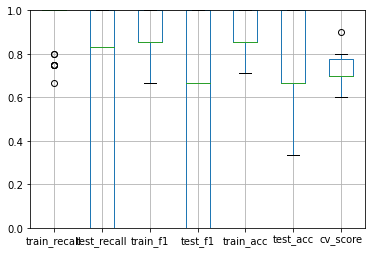

In [15]:
train_recall_lr = []
test_recall_lr = []

train_f1_lr = []
test_f1_lr = []

train_acc_lr = []
test_acc_lr = []

cv_score = []
auc_score = []

for i in range(30):
    gait_label_0 = gait_baseline[gait_baseline['label']==0]
    gait_label_1 = gait_baseline[gait_baseline['label']==1]

    gait_label_0_train = gait_label_0
    gait_label_1_train = gait_label_1

    gait_baseline_model_dataset = pd.concat([gait_label_0_train, gait_label_1_train])

    gait_baseline_model_dataset = shuffle(gait_baseline_model_dataset).reset_index(drop=True) # disrupt the order

    X = gait_baseline_model_dataset.iloc[:, 0:-1]
    Y = gait_baseline_model_dataset.iloc[:, -1]
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=1234)

    # normalisation
    X_scaler = StandardScaler().fit(X_train)
    standardized_X_train = X_scaler.transform(X_train)
    standardized_X_test = X_scaler.transform(X_test)

    # Initialising the model and training
    # linear_svc = SVC(kernel='linear', C=0.5, class_weight='balanced', random_state=10).fit(X_train, y_train)    
    forest = RandomForestClassifier(n_estimators=5, max_depth=4, min_samples_leaf=2,min_samples_split=3,max_features='auto',random_state=10).fit(X_train, y_train)    
    # prediction and results
    training = forest.predict(X_train)
    testing=forest.predict(X_test)

    train_recall = recall_score(training,y_train)
    train_f1 = f1_score(training,y_train)
    train_accuracy = accuracy_score(training,y_train)

    test_recall = recall_score(testing,y_test)
    test_f1 = f1_score(testing,y_test)
    test_accuracy = accuracy_score(testing,y_test)

    train_recall_i = train_recall
    test_recall_i = test_recall

    train_f1_i = train_f1
    test_f1_i = test_f1

    train_acc_i = train_accuracy
    test_acc_i = test_accuracy

    train_recall_lr.append(train_recall_i)
    test_recall_lr.append(test_recall_i)
    train_f1_lr.append(train_f1_i)
    test_f1_lr.append(test_f1_i)
    train_acc_lr.append(train_acc_i)
    test_acc_lr.append(test_acc_i)

    cv_scores_i = cross_val_score(forest, X, Y, cv=5)
    cv_score.append(cv_scores_i.mean())

    auc_score_i = average_precision_score(testing,y_test)
    auc_score.append(auc_score_i)

    # print(y_test)
    # print(testing)

train_recall_lr = pd.DataFrame(train_recall_lr, columns=['train_recall'])
test_recall_lr = pd.DataFrame(test_recall_lr, columns=['test_recall'])
train_f1_lr = pd.DataFrame(train_f1_lr, columns=['train_f1'])
test_f1_lr = pd.DataFrame(test_f1_lr, columns = ['test_f1'])
train_acc_lr = pd.DataFrame(train_acc_lr, columns=['train_acc'])
test_acc_lr = pd.DataFrame(test_acc_lr, columns=['test_acc'])
cv_score = pd.DataFrame(cv_score, columns=['cv_score'])
auc_score = pd.DataFrame(auc_score, columns=['auc_score'])
all_events_recall_logic_reg = pd.concat([train_recall_lr, test_recall_lr, train_f1_lr, test_f1_lr,train_acc_lr,test_acc_lr,cv_score],axis=1)
# all_events_recall_logic_reg = pd.concat([cv_score],axis=1)
# all_events_recall_logic_reg.to_csv('result_baseline_lr.csv')
all_events_recall_logic_reg.boxplot()  
plt.ylim(0,1) 
print(all_events_recall_logic_reg.mean())

In [16]:
all_events_recall_logic_reg.to_csv('result_baseline_rf.csv')

In [ ]:
from sklearn.model_selection import GridSearchCV
param_test1 = {'n_estimators':range(1,21,1)}
gsearch1 = GridSearchCV(estimator = RandomForestClassifier(max_depth=8,max_features='sqrt' ,random_state=10), 
                       param_grid = param_test1, scoring='roc_auc',cv=5)
gsearch1.fit(X,Y)
gsearch1.cv_results_['mean_train_score']